In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

import tensorflow as tf
import abc

# %matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils as Hunch
import Dummy_g1data as dummy
import models.AEFIT as aefit

plt.ion()
plt.show()

ds = dummy.Dummy_g1data()
m = aefit.AEFIT(latent_dim=2)

# aefit.test_dummy(m)


reload set for module  Hunch_utils
reload set for module  models.AEFIT
reload set for module  models.SPFIT


<IPython.core.display.Javascript object>


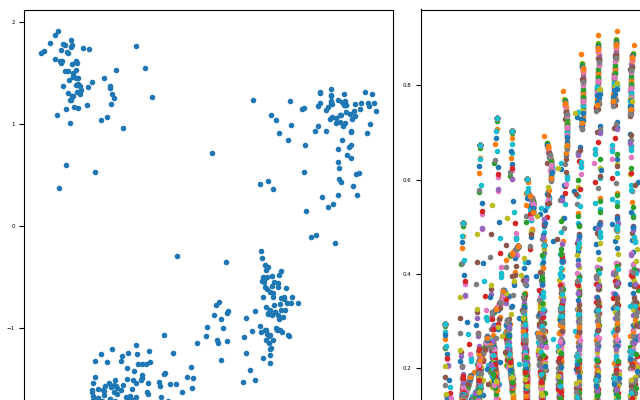

W0424 09:42:08.687953 140126970427200 deprecation.py:323] From /home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:410: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0424 09:42:08.710978

0-20 loss: 23.487177
0-40 loss: 22.879963
0-60 loss: 22.209253
0-80 loss: 22.273291
0-100 loss: 21.881041
0-120 loss: 21.974131
0-140 loss: 21.679293
1-160 loss: 21.783457
1-180 loss: 21.771431
1-200 loss: 21.837105
1-220 loss: 21.724882
1-240 loss: 21.646425
1-260 loss: 22.000322
1-280 loss: 21.927673
1-300 loss: 21.775606
2-320 loss: 21.468857
2-340 loss: 21.286449
2-360 loss: 21.636431


KeyboardInterrupt: 